In [ ]:
# Credits
# https://www.kaggle.com/code/datafan07/top-1-approach-eda-new-models-and-stacking/notebook


In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
from scipy.stats import skew, boxcox_normmax, norm
from scipy.special import boxcox1p
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import warnings

pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')

In [109]:
# Load the CSV file
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Dropping unnecessary Id column.
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

# Backing up target variables and dropping them from train data.
y = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

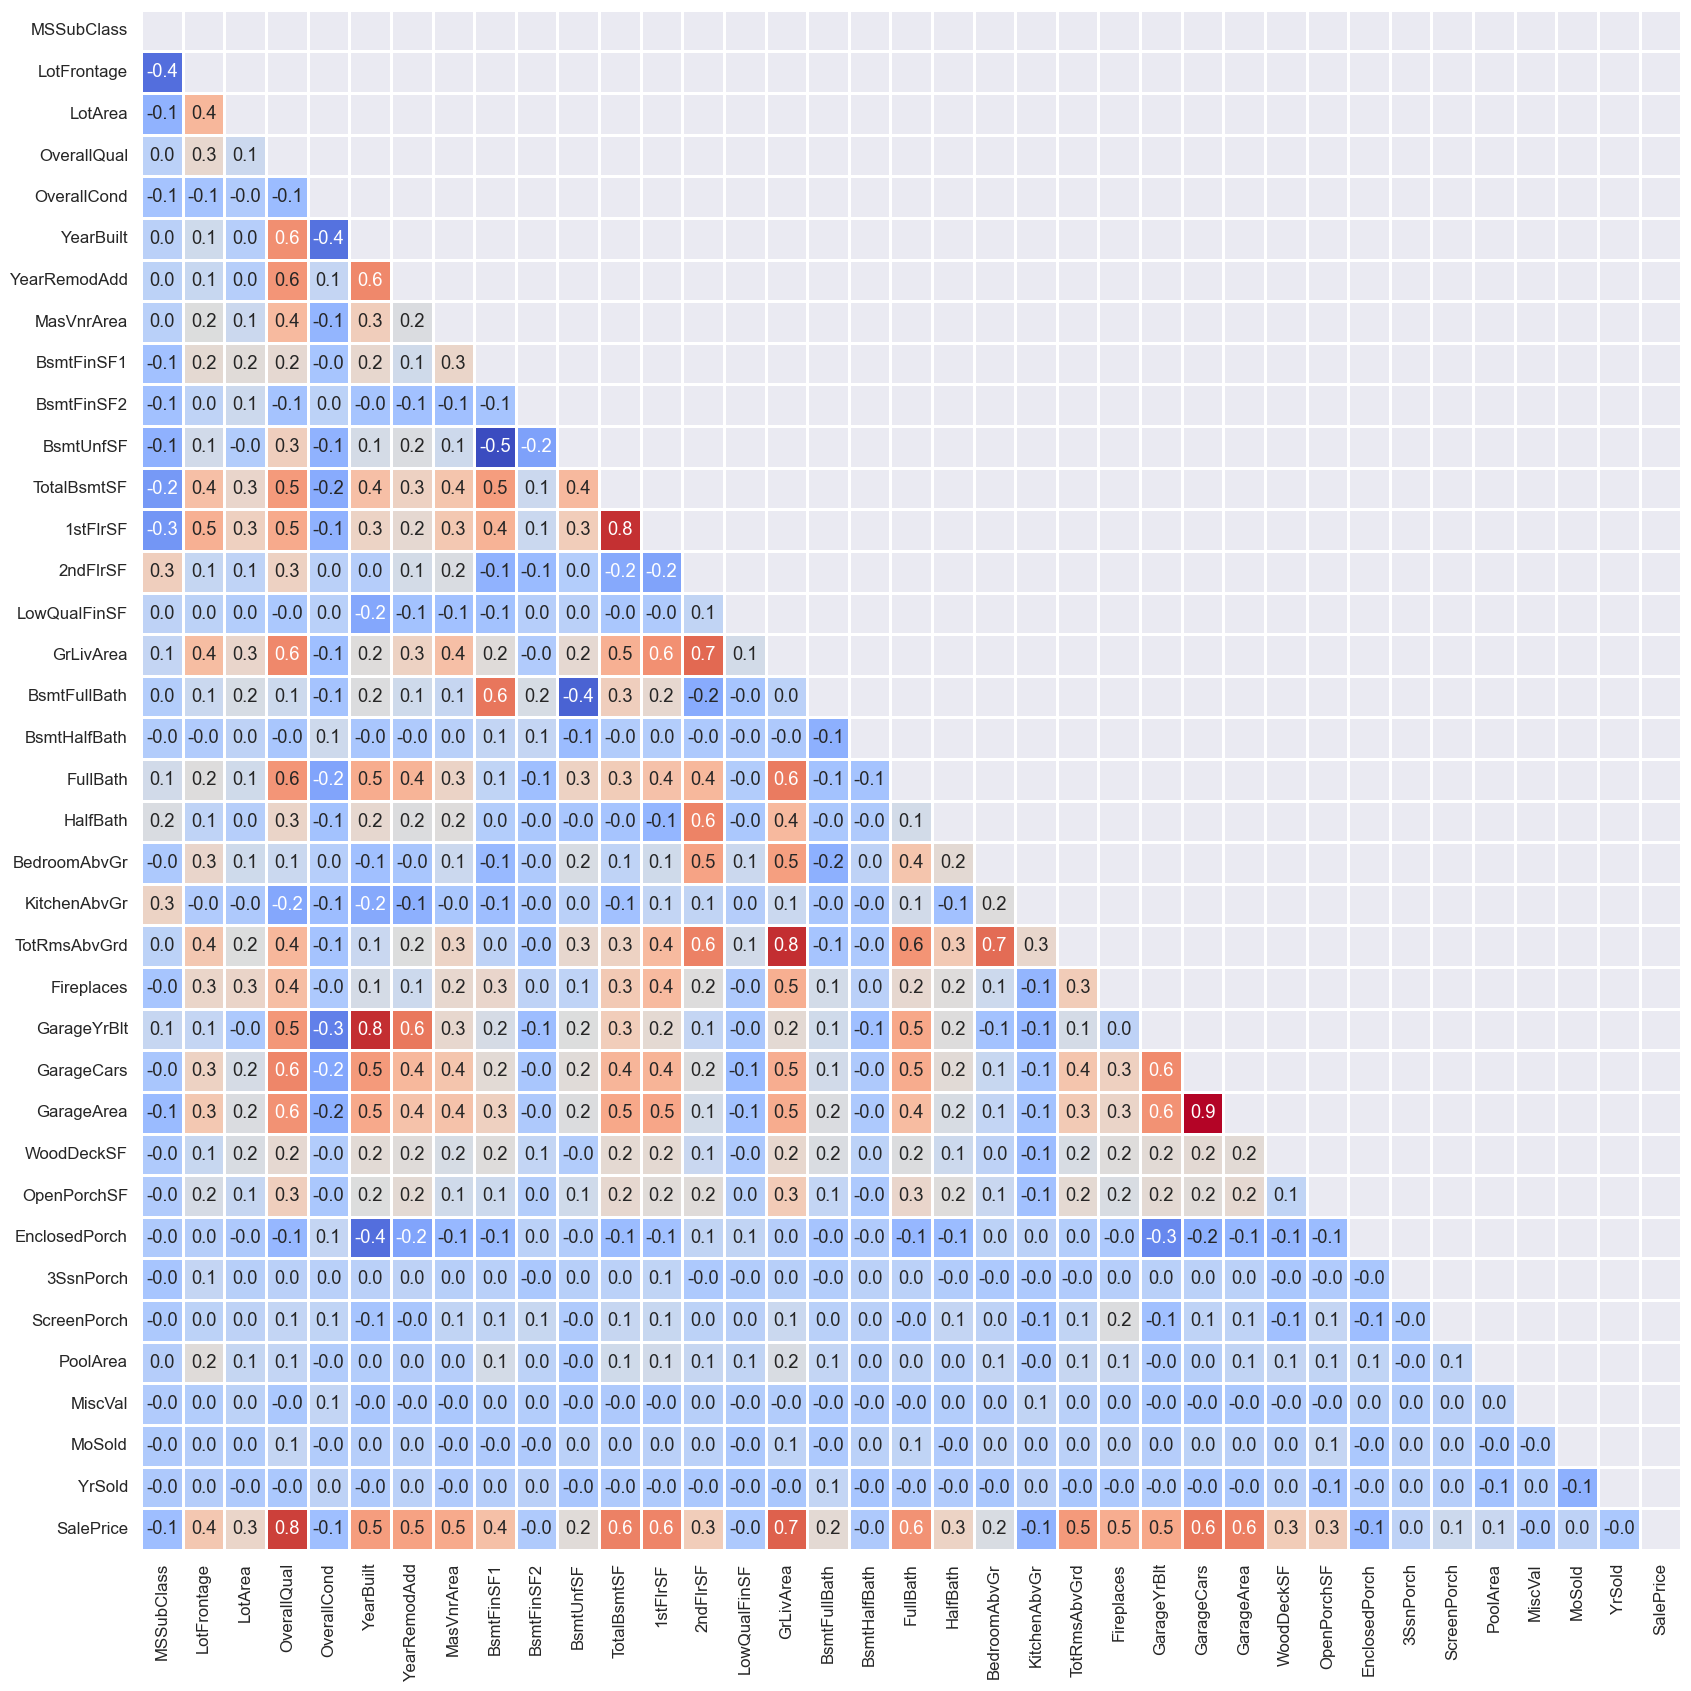

In [110]:
# Display numerical correlations (pearson) between features on heatmap.
sns.set(font_scale=1.1)
correlation_train = train.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False)

plt.show()

In [111]:
# Merging train test features for engineering.
features = pd.concat([train_features, test_features]).reset_index(drop=True)
print(features.shape)

(2919, 79)


In [112]:
def missing_percentage(df):
    
    """A function for returning missing ratios."""
    
    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

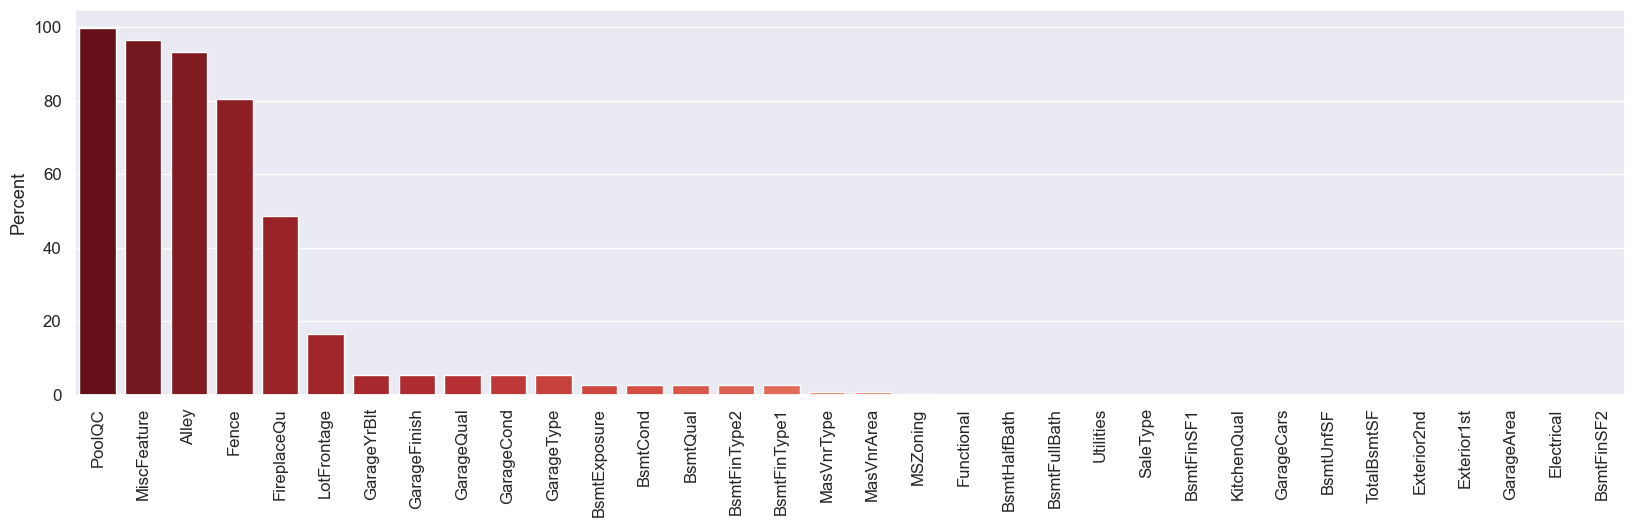

In [113]:
# Checking 'NaN' values.

missing = missing_percentage(features)

fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=missing.index, y='Percent', data=missing, palette='Reds_r')
plt.xticks(rotation=90)

display(missing.T.style.background_gradient(cmap='Reds', axis=1))

In [114]:
# List of 'NaN' including columns where NaN's mean none.
none_cols = [
    'Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]

# List of 'NaN' including columns where NaN's mean 0.
zero_cols = [
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
    'BsmtHalfBath', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea'
]

# List of 'NaN' including columns where NaN's actually missing gonna replaced with mode.
freq_cols = [
    'Electrical', 'Exterior1st', 'Exterior2nd', 'Functional', 'KitchenQual',
    'SaleType', 'Utilities'
]

# Filling the list of columns above with appropriate values:
for col in zero_cols:
    features[col].replace(np.nan, 0, inplace=True)

for col in none_cols:
    features[col].replace(np.nan, 'None', inplace=True)

for col in freq_cols:
    features[col].replace(np.nan, features[col].mode()[0], inplace=True)

In [115]:
# Filling 'MSZoning' according to MSSubClass.
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].apply(
    lambda x: x.fillna(x.mode()[0]))

In [116]:
# Filling 'LotFrontage' according to Neighborhood.
features['LotFrontage'] = features.groupby(
    ['Neighborhood'])['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [117]:
# Features which numerical on data but should be treated as category:
features['MSSubClass'] = features['MSSubClass'].astype(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

In [118]:
# Transforming rare values(less than 10) into one group.
others = [
    'Condition1', 'Condition2', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
    'Heating', 'Electrical', 'Functional', 'SaleType'
]

for col in others:
    mask = features[col].isin(
        features[col].value_counts()[features[col].value_counts() < 10].index)
    features[col][mask] = 'Other'

In [119]:
def srt_box(y, df):
    
    '''A function for displaying categorical variables.'''
    
    fig, axes = plt.subplots(14, 3, figsize=(25, 80))
    axes = axes.flatten()

    for i, j in zip(df.select_dtypes(include=['object']).columns, axes):

        sortd = df.groupby([i])[y].median().sort_values(ascending=False)
        sns.boxplot(x=i,
                    y=y,
                    data=df,
                    palette='plasma',
                    order=sortd.index,
                    ax=j)
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=18))

        plt.tight_layout()

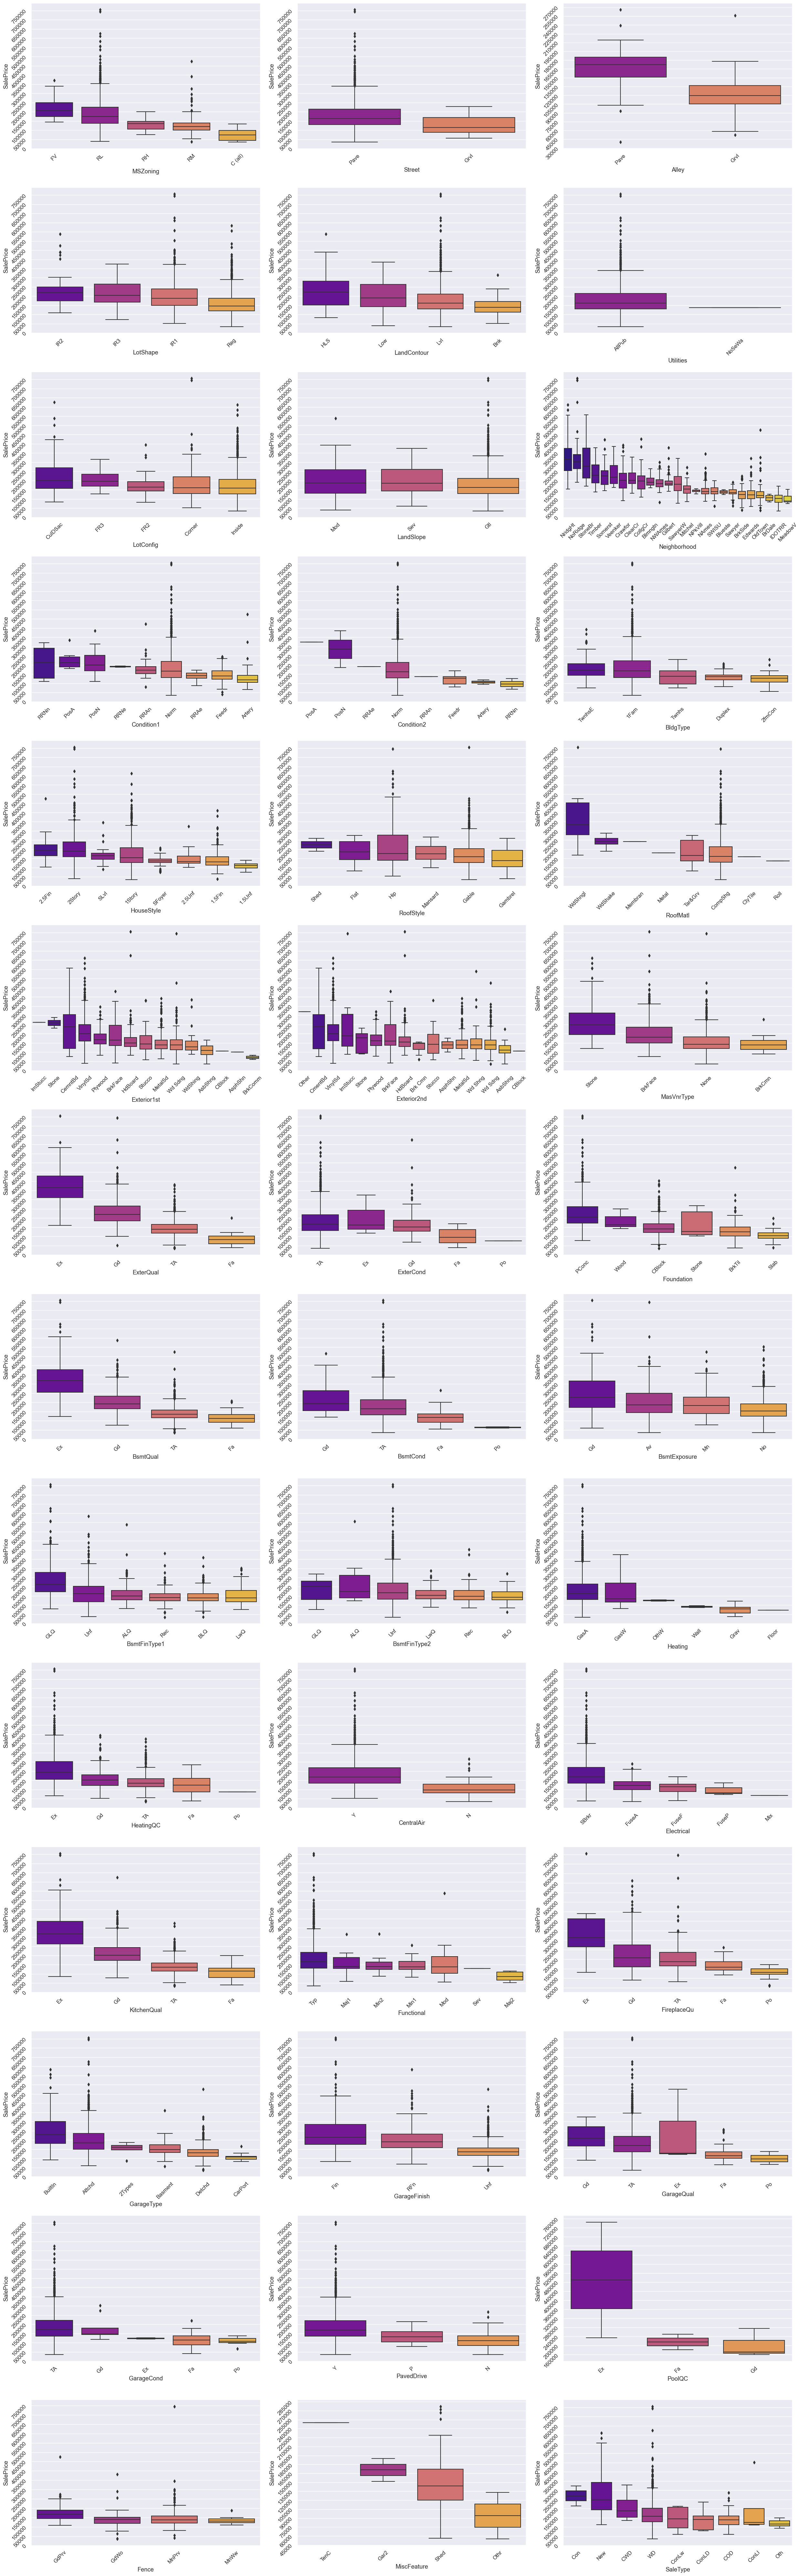

In [100]:
# Displaying sale prices vs. categorical values:
srt_box('SalePrice', train)

In [120]:
# Converting some of the categorical values to numeric ones. Choosing similar values for closer groups to balance linear relations...

neigh_map = {
    'MeadowV': 1,
    'IDOTRR': 1,
    'BrDale': 1,
    'BrkSide': 2,
    'OldTown': 2,
    'Edwards': 2,
    'Sawyer': 3,
    'Blueste': 3,
    'SWISU': 3,
    'NPkVill': 3,
    'NAmes': 3,
    'Mitchel': 4,
    'SawyerW': 5,
    'NWAmes': 5,
    'Gilbert': 5,
    'Blmngtn': 5,
    'CollgCr': 5,
    'ClearCr': 6,
    'Crawfor': 6,
    'Veenker': 7,
    'Somerst': 7,
    'Timber': 8,
    'StoneBr': 9,
    'NridgHt': 10,
    'NoRidge': 10
}

features['Neighborhood'] = features['Neighborhood'].map(neigh_map).astype(
    'int')
ext_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['ExterQual'] = features['ExterQual'].map(ext_map).astype('int')
features['ExterCond'] = features['ExterCond'].map(ext_map).astype('int')
bsm_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['BsmtQual'] = features['BsmtQual'].map(bsm_map).astype('int')
features['BsmtCond'] = features['BsmtCond'].map(bsm_map).astype('int')
bsmf_map = {
    'None': 0,
    'Unf': 1,
    'LwQ': 2,
    'Rec': 3,
    'BLQ': 4,
    'ALQ': 5,
    'GLQ': 6
}

features['BsmtFinType1'] = features['BsmtFinType1'].map(bsmf_map).astype('int')
features['BsmtFinType2'] = features['BsmtFinType2'].map(bsmf_map).astype('int')
heat_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
features['HeatingQC'] = features['HeatingQC'].map(heat_map).astype('int')
features['KitchenQual'] = features['KitchenQual'].map(heat_map).astype('int')
features['FireplaceQu'] = features['FireplaceQu'].map(bsm_map).astype('int')
features['GarageCond'] = features['GarageCond'].map(bsm_map).astype('int')
features['GarageQual'] = features['GarageQual'].map(bsm_map).astype('int')

In [102]:
# Plotting numerical features with polynomial order to detect outliers by eye.

def srt_reg(y, df):
    fig, axes = plt.subplots(12, 3, figsize=(25, 80))
    axes = axes.flatten()

    for i, j in zip(df.select_dtypes(include=['number']).columns, axes):

        sns.regplot(x=i,
                    y=y,
                    data=df,
                    ax=j,
                    order=3,
                    ci=None,
                    color='#e74c3c',
                    line_kws={'color': 'black'},
                    scatter_kws={'alpha':0.4})
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=10))

        plt.tight_layout()

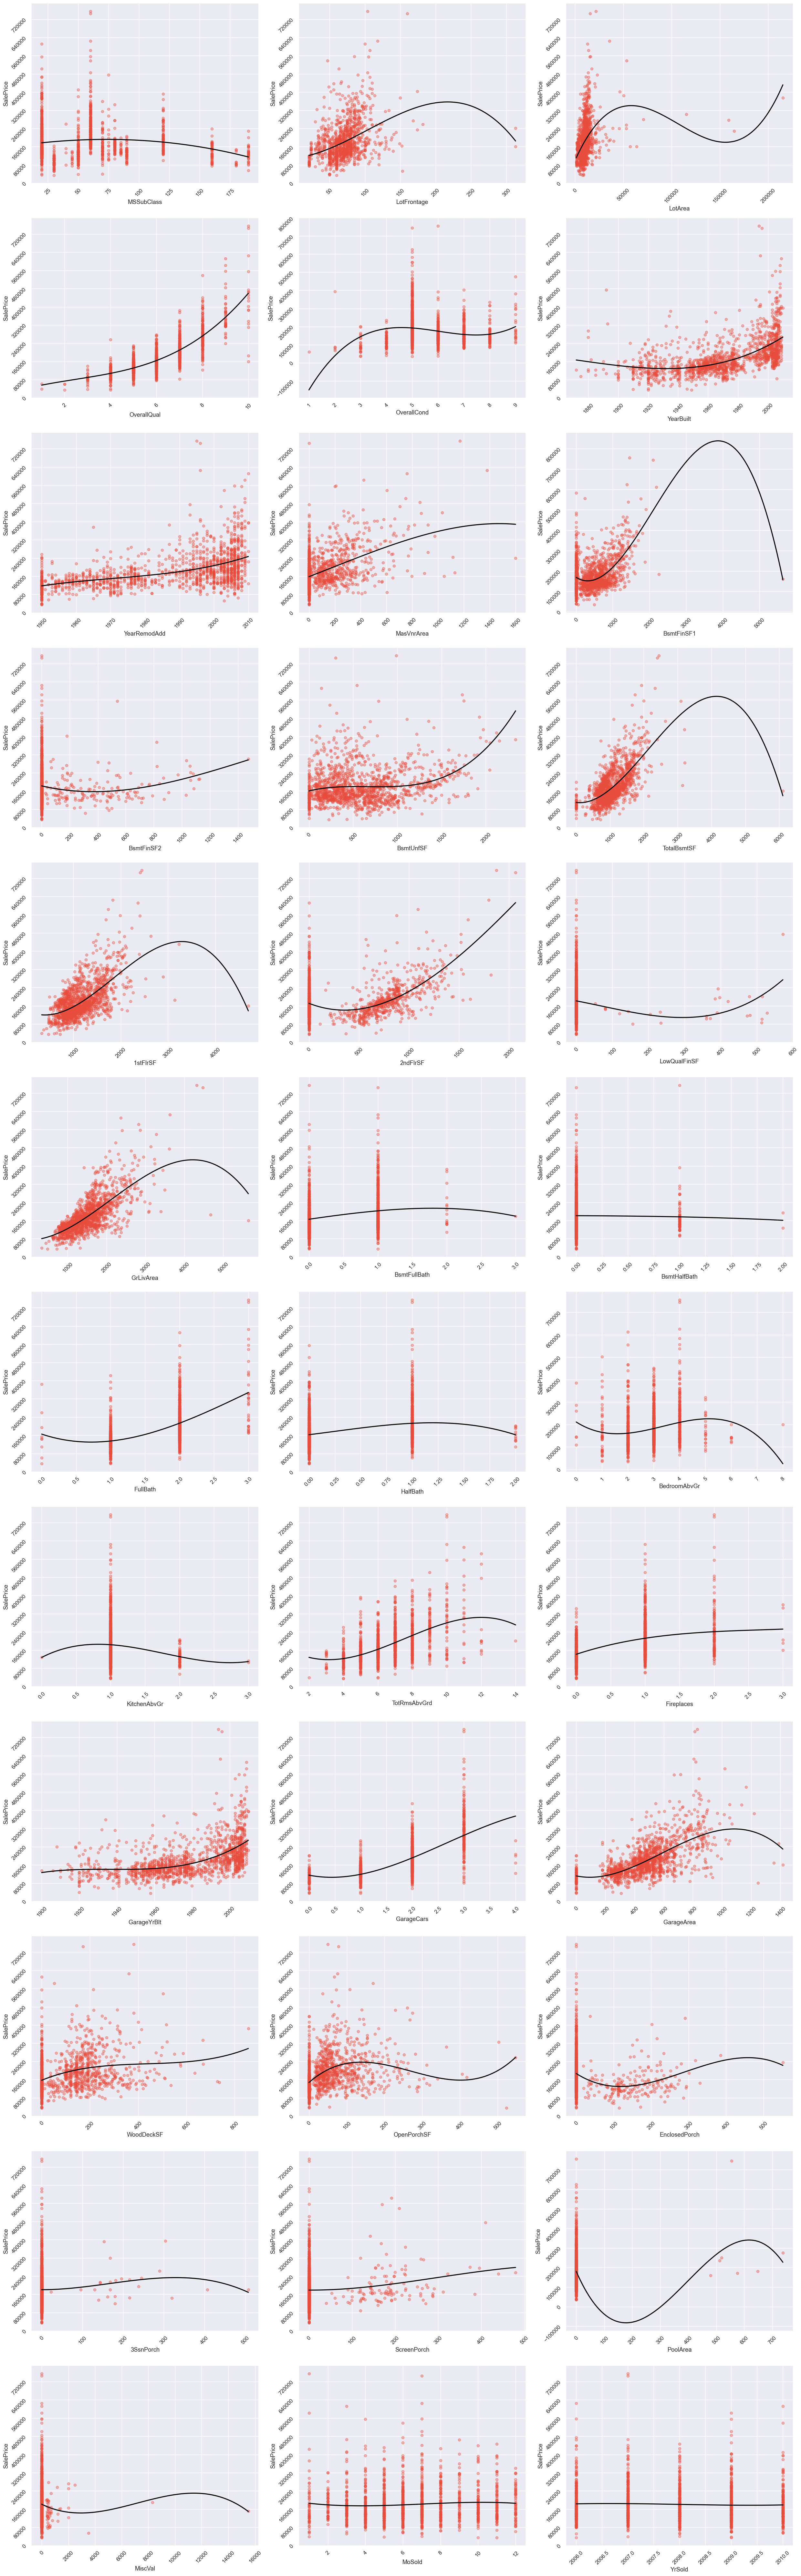

In [103]:

srt_reg('SalePrice', train)

In [124]:
features.join(y)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0            60       RL         65.0     8450   Pave  None      Reg   
1            20       RL         80.0     9600   Pave  None      Reg   
2            60       RL         68.0    11250   Pave  None      IR1   
3            70       RL         60.0     9550   Pave  None      IR1   
4            60       RL         84.0    14260   Pave  None      IR1   
...         ...      ...          ...      ...    ...   ...      ...   
2914        160       RM         21.0     1936   Pave  None      Reg   
2915        160       RM         21.0     1894   Pave  None      Reg   
2916         20       RL        160.0    20000   Pave  None      Reg   
2917         85       RL         62.0    10441   Pave  None      Reg   
2918         60       RL         74.0     9627   Pave  None      Reg   

     LandContour Utilities LotConfig LandSlope  Neighborhood Condition1  \
0            Lvl    AllPub    Inside       Gtl             5       Norm   
1            Lvl    AllPub       FR2       Gtl             7      Feedr   
2            Lvl    AllPub    Inside       Gtl             5       Norm   
3            Lvl    AllPub    Corner       Gtl             6       Norm   
4            Lvl    AllPub       FR2       Gtl            10       Norm   
...          ...       ...       ...       ...           ...        ...   
2914         Lvl    AllPub    Inside       Gtl             1       Norm   
2915         Lvl    AllPub    Inside       Gtl             1       Norm   
2916         Lvl    AllPub    Inside       Gtl             4       Norm   
2917         Lvl    AllPub    Inside       Gtl             4       Norm   
2918         Lvl    AllPub    Inside       Mod             4       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0          Norm     1Fam     2Story            7            5       2003   
1          Norm     1Fam     1Story            6            8       1976   
2          Norm     1Fam     2Story            7            5       2001   
3          Norm     1Fam     2Story            7            5       1915   
4          Norm     1Fam     2Story            8            5       2000   
...         ...      ...        ...          ...          ...        ...   
2914       Norm    Twnhs     2Story            4            7       1970   
2915       Norm   TwnhsE     2Story            4            5       1970   
2916       Norm     1Fam     1Story            5            7       1960   
2917       Norm     1Fam     SFoyer            5            5       1992   
2918       Norm     1Fam     2Story            7            5       1993   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0             2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1             1976     Gable  CompShg     MetalSd     MetalSd       None   
2             2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3             1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4             2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
...            ...       ...      ...         ...         ...        ...   
2914          1970     Gable  CompShg     CemntBd     CmentBd       None   
2915          1970     Gable  CompShg     CemntBd     CmentBd       None   
2916          1996     Gable  CompShg     VinylSd     VinylSd       None   
2917          1992     Gable  CompShg     HdBoard     Wd Shng       None   
2918          1994     Gable  CompShg     HdBoard     HdBoard    BrkFace   

      MasVnrArea  ExterQual  ExterCond Foundation  BsmtQual  BsmtCond  \
0          196.0          4          3      PConc         4         3   
1            0.0          3          3     CBlock         4         3   
2          162.0          4          3      PConc         4         3   
3            0.0          3          3     BrkTil         3         4   
4          350.0          4          3      PCon

In [122]:
features.merge(y, left_index=True, right_index=True, how='left')

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0            60       RL         65.0     8450   Pave  None      Reg   
1            20       RL         80.0     9600   Pave  None      Reg   
2            60       RL         68.0    11250   Pave  None      IR1   
3            70       RL         60.0     9550   Pave  None      IR1   
4            60       RL         84.0    14260   Pave  None      IR1   
...         ...      ...          ...      ...    ...   ...      ...   
2914        160       RM         21.0     1936   Pave  None      Reg   
2915        160       RM         21.0     1894   Pave  None      Reg   
2916         20       RL        160.0    20000   Pave  None      Reg   
2917         85       RL         62.0    10441   Pave  None      Reg   
2918         60       RL         74.0     9627   Pave  None      Reg   

     LandContour Utilities LotConfig LandSlope  Neighborhood Condition1  \
0            Lvl    AllPub    Inside       Gtl             5       Norm   
1            Lvl    AllPub       FR2       Gtl             7      Feedr   
2            Lvl    AllPub    Inside       Gtl             5       Norm   
3            Lvl    AllPub    Corner       Gtl             6       Norm   
4            Lvl    AllPub       FR2       Gtl            10       Norm   
...          ...       ...       ...       ...           ...        ...   
2914         Lvl    AllPub    Inside       Gtl             1       Norm   
2915         Lvl    AllPub    Inside       Gtl             1       Norm   
2916         Lvl    AllPub    Inside       Gtl             4       Norm   
2917         Lvl    AllPub    Inside       Gtl             4       Norm   
2918         Lvl    AllPub    Inside       Mod             4       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0          Norm     1Fam     2Story            7            5       2003   
1          Norm     1Fam     1Story            6            8       1976   
2          Norm     1Fam     2Story            7            5       2001   
3          Norm     1Fam     2Story            7            5       1915   
4          Norm     1Fam     2Story            8            5       2000   
...         ...      ...        ...          ...          ...        ...   
2914       Norm    Twnhs     2Story            4            7       1970   
2915       Norm   TwnhsE     2Story            4            5       1970   
2916       Norm     1Fam     1Story            5            7       1960   
2917       Norm     1Fam     SFoyer            5            5       1992   
2918       Norm     1Fam     2Story            7            5       1993   

      YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0             2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1             1976     Gable  CompShg     MetalSd     MetalSd       None   
2             2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3             1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4             2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
...            ...       ...      ...         ...         ...        ...   
2914          1970     Gable  CompShg     CemntBd     CmentBd       None   
2915          1970     Gable  CompShg     CemntBd     CmentBd       None   
2916          1996     Gable  CompShg     VinylSd     VinylSd       None   
2917          1992     Gable  CompShg     HdBoard     Wd Shng       None   
2918          1994     Gable  CompShg     HdBoard     HdBoard    BrkFace   

      MasVnrArea  ExterQual  ExterCond Foundation  BsmtQual  BsmtCond  \
0          196.0          4          3      PConc         4         3   
1            0.0          3          3     CBlock         4         3   
2          162.0          4          3      PConc         4         3   
3            0.0          3          3     BrkTil         3         4   
4          350.0          4          3      PCon

In [125]:
# Dropping outliers after detecting them by eye.
features = features.join(y)
features = features.drop(features[(features['OverallQual'] < 5)
                                  & (features['SalePrice'] > 200000)].index)
features = features.drop(features[(features['GrLivArea'] > 4000)
                                  & (features['SalePrice'] < 200000)].index)
features = features.drop(features[(features['GarageArea'] > 1200)
                                  & (features['SalePrice'] < 200000)].index)
features = features.drop(features[(features['TotalBsmtSF'] > 3000)
                                  & (features['SalePrice'] > 320000)].index)
features = features.drop(features[(features['1stFlrSF'] < 3000)
                                  & (features['SalePrice'] > 600000)].index)
features = features.drop(features[(features['1stFlrSF'] > 3000)
                                  & (features['SalePrice'] < 200000)].index)

y = features['SalePrice']
y.dropna(inplace=True)
features.drop(columns='SalePrice', inplace=True)

In [126]:
# Creating new features  based on previous observations. There might be some highly correlated features now. You cab drop them if you want to...

features['TotalSF'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                       features['1stFlrSF'] + features['2ndFlrSF'])
features['TotalBathrooms'] = (features['FullBath'] +
                              (0.5 * features['HalfBath']) +
                              features['BsmtFullBath'] +
                              (0.5 * features['BsmtHalfBath']))

features['TotalPorchSF'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                            features['EnclosedPorch'] +
                            features['ScreenPorch'] + features['WoodDeckSF'])

features['YearBlRm'] = (features['YearBuilt'] + features['YearRemodAdd'])

# Merging quality and conditions.

features['TotalExtQual'] = (features['ExterQual'] + features['ExterCond'])
features['TotalBsmQual'] = (features['BsmtQual'] + features['BsmtCond'] +
                            features['BsmtFinType1'] +
                            features['BsmtFinType2'])
features['TotalGrgQual'] = (features['GarageQual'] + features['GarageCond'])
features['TotalQual'] = features['OverallQual'] + features[
    'TotalExtQual'] + features['TotalBsmQual'] + features[
        'TotalGrgQual'] + features['KitchenQual'] + features['HeatingQC']

# Creating new features by using new quality indicators.

features['QualGr'] = features['TotalQual'] * features['GrLivArea']
features['QualBsm'] = features['TotalBsmQual'] * (features['BsmtFinSF1'] +
                                                  features['BsmtFinSF2'])
features['QualPorch'] = features['TotalExtQual'] * features['TotalPorchSF']
features['QualExt'] = features['TotalExtQual'] * features['MasVnrArea']
features['QualGrg'] = features['TotalGrgQual'] * features['GarageArea']
features['QlLivArea'] = (features['GrLivArea'] -
                         features['LowQualFinSF']) * (features['TotalQual'])
features['QualSFNg'] = features['QualGr'] * features['Neighborhood']

In [31]:
# Observing the effects of newly created features on sale price.

def srt_reg(feature):
    merged = features.join(y)
    fig, axes = plt.subplots(5, 3, figsize=(25, 40))
    axes = axes.flatten()

    new_features = [
        'TotalSF', 'TotalBathrooms', 'TotalPorchSF', 'YearBlRm',
        'TotalExtQual', 'TotalBsmQual', 'TotalGrgQual', 'TotalQual', 'QualGr',
        'QualBsm', 'QualPorch', 'QualExt', 'QualGrg', 'QlLivArea', 'QualSFNg'
    ]

    for i, j in zip(new_features, axes):

        sns.regplot(x=i,
                    y=feature,
                    data=merged,
                    ax=j,
                    order=3,
                    ci=None,
                    color='#e74c3c',
                    line_kws={'color': 'black'},
                    scatter_kws={'alpha':0.4})
        j.tick_params(labelrotation=45)
        j.yaxis.set_major_locator(MaxNLocator(nbins=10))

        plt.tight_layout()

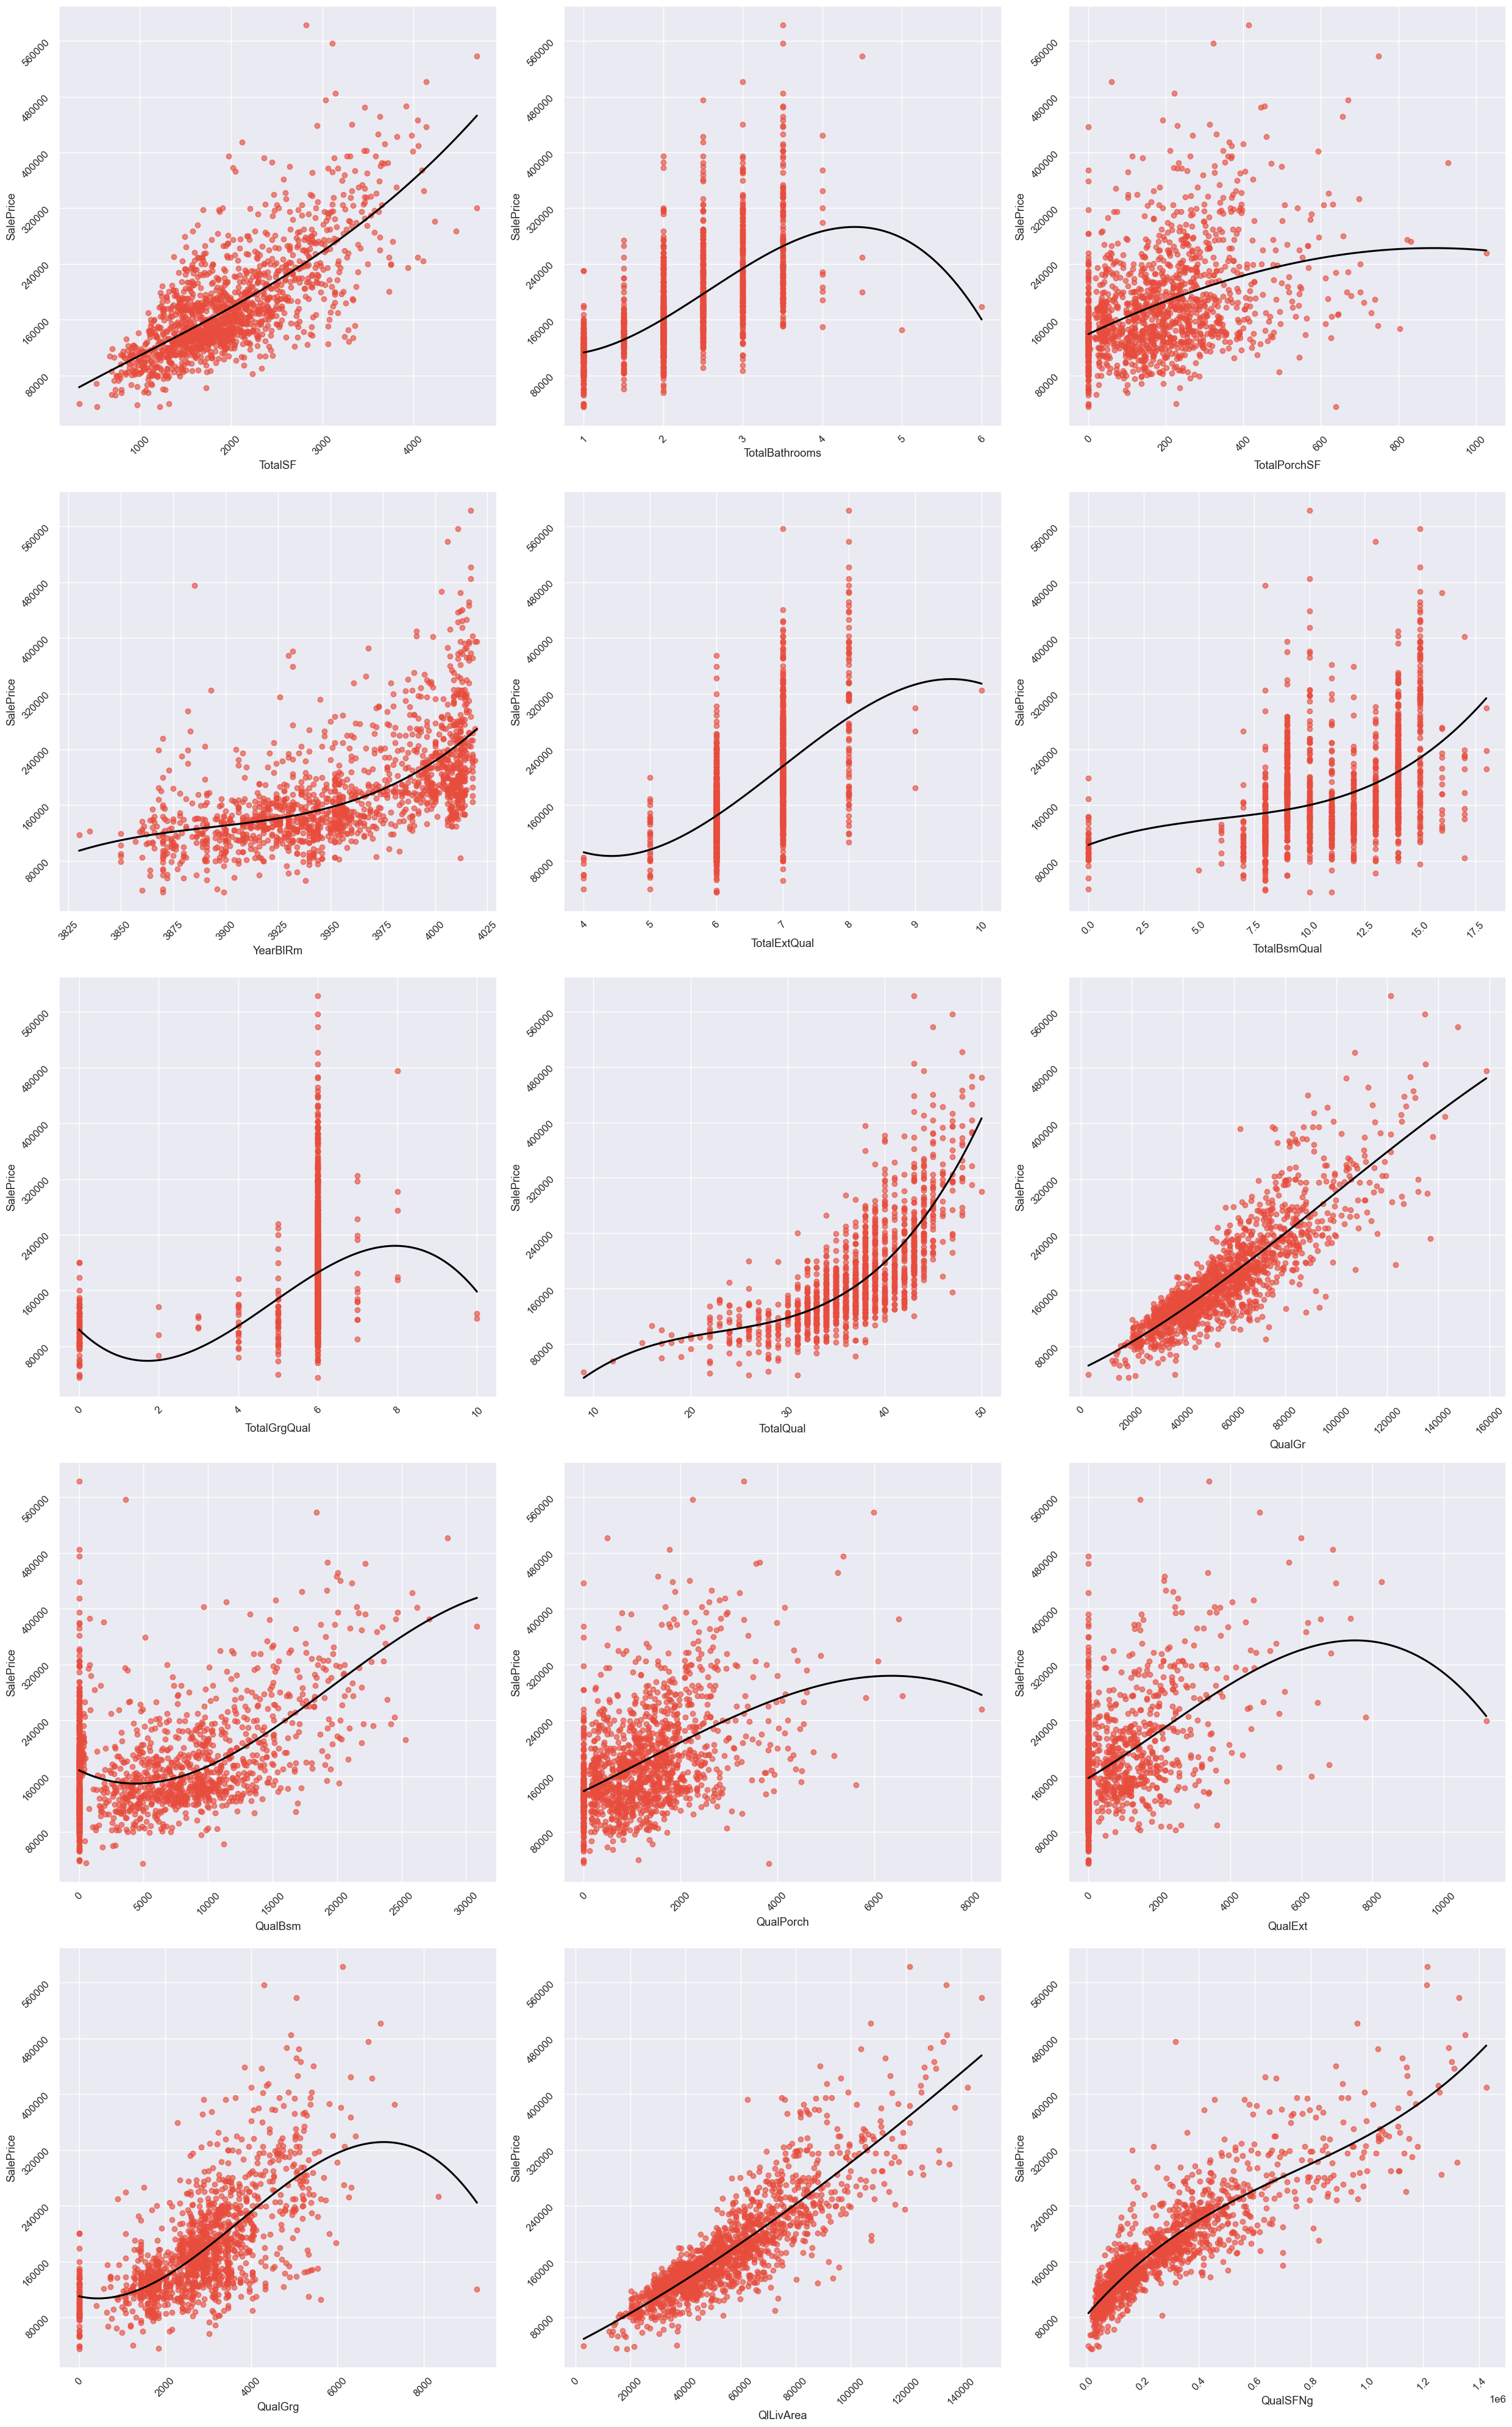

In [32]:
srt_reg('SalePrice')

In [127]:
# Creating some simple features.

features['HasPool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['Has2ndFloor'] = features['2ndFlrSF'].apply(lambda x: 1
                                                     if x > 0 else 0)
features['HasGarage'] = features['QualGrg'].apply(lambda x: 1 if x > 0 else 0)
features['HasBsmt'] = features['QualBsm'].apply(lambda x: 1 if x > 0 else 0)
features['HasFireplace'] = features['Fireplaces'].apply(lambda x: 1
                                                        if x > 0 else 0)
features['HasPorch'] = features['QualPorch'].apply(lambda x: 1 if x > 0 else 0)

In [128]:
# Numerical features we worked on which seems highly skewed but we filter again anyways...

skewed = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
    'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
    'ScreenPorch', 'PoolArea', 'LowQualFinSF', 'MiscVal'
]

In [129]:
# Finding skewness of the numerical features.

skew_features = np.abs(features[skewed].apply(lambda x: skew(x)).sort_values(
    ascending=False))

# Filtering skewed features.

high_skew = skew_features[skew_features > 0.3]

# Taking indexes of high skew.

skew_index = high_skew.index

# Applying boxcox transformation to fix skewness.

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

In [130]:
# Features to drop:

to_drop = [
    'Utilities',
    'PoolQC',
    'YrSold',
    'MoSold',
    'ExterQual',
    'BsmtQual',
    'GarageQual',
    'KitchenQual',
    'HeatingQC',
]

# Dropping features.
features.drop(columns=to_drop, inplace=True)

In [131]:
# Getting dummy variables for categorical data.
features = pd.get_dummies(data=features)

In [132]:
# Separating train and test set.
train = features.iloc[:len(y), :]
test = features.iloc[len(train):, :]

In [133]:
test

LotFrontage    LotArea  Neighborhood  OverallQual  OverallCond  \
1460    20.976654  14.839858             3            5            6   
1461    21.141446  15.329119             3            6            6   
1462    19.969817  15.254296             5            5            5   
1463    20.644547  14.481880             5            6            6   
1464    14.119319  12.923806             9            8            5   
...           ...        ...           ...          ...          ...   
2914     8.809474  10.934602             1            4            7   
2915     8.809474  10.890695             1            4            5   
2916    32.312793  16.155482             4            5            7   
2917    17.851160  14.587817             4            5            5   
2918    19.969817  14.398553             4            7            5   

      YearBuilt  YearRemodAdd  MasVnrArea  ExterCond  BsmtCond  BsmtFinType1  \
1460       1961          1961    0.000000          3         3             3   
1461       1958          1958   14.879808          3         3             5   
1462       1997          1998    0.000000          3         3             6   
1463       1998          1998    6.216839          3         3             6   
1464       1992          1992    0.000000          3         3             5   
...         ...           ...         ...        ...       ...           ...   
2914       1970          1970    0.000000          3         3             1   
2915       1970          1970    0.000000          3         3             3   
2916       1960          1996    0.000000          3         3             5   
2917       1992          1992    0.000000          3         3             6   
2918       1993          1994   13.903764          3         3             2   

      BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
1460  109.527263             2    7.749637  42.965291   474.036922  6.301935   
1461  178.121593             1    0.000000  54.886390   683.537244  6.638154   
1462  159.512073             1    0.000000  28.461715   496.049937  6.331978   
1463  131.194553             1    0.000000  47.944966   495.095344  6.330131   
1464   72.365251             1    0.000000  94.746603   660.997816  6.606240   
...          ...           ...         ...        ...          ...       ...   
2914    0.000000             1    0.000000  65.503509   308.889037  5.875466   
2915   70.169644             1    0.000000  45.225402   308.889037  5.875466   
2916  217.909774             1    0.000000   0.000000   635.123696  6.568202   
2917   86.510661             1    0.000000  67.553382   488.406920  6.369842   
2918  154.722864             1    0.000000  39.816835   528.377104  6.392451   

         2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
1460     0.000000           0.0   8.474237           0.0           0.0   
1461     0.000000           0.0   9.084459           0.0           0.0   
1462   954.094520           0.0   9.405520           0.0           0.0   
1463   921.108124           0.0   9.380979           0.0           0.0   
1464     0.000000           0.0   9.025652           0.0           0.0   
...           ...           ...        ...           ...           ...   
2914   733.052562           0.0   8.778531           0.0           0.0   
2915   733.052562           0.0   8.778531           0.0           0.0   
2916     0.000000           0.0   8.955805           1.0           0.0   
2917     0.000000           0.0   8.595842           0.0           1.0   
2918  1393.643878           0.0   9.733373           0.0           0.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  \
1460         1         0             2             1             5   
1461         1         1             3             1             6   
1462         2         1             3             1             6   
1463         2         1             3            

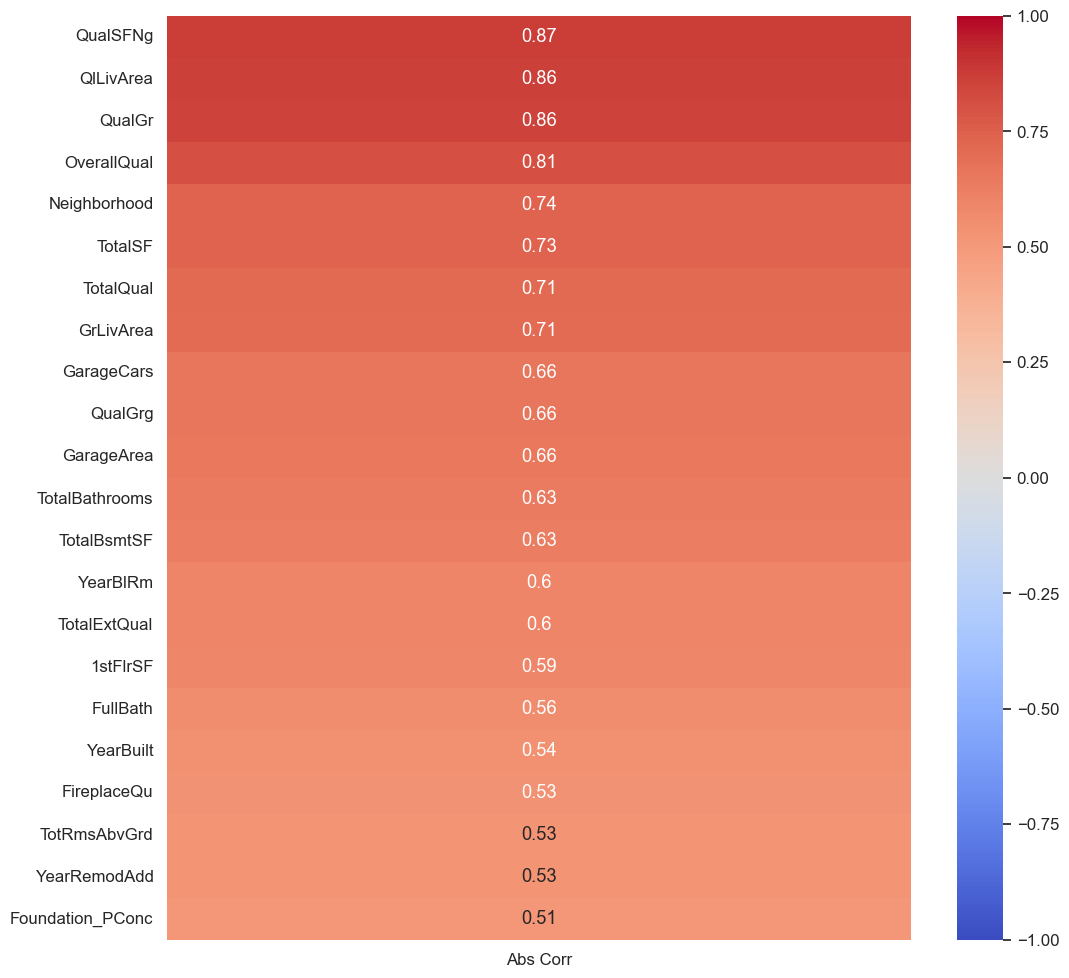

In [42]:
correlations = train.join(y).corrwith(train.join(y)['SalePrice']).iloc[:-1].to_frame()
correlations['Abs Corr'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('Abs Corr', ascending=False)['Abs Corr']
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(sorted_correlations.to_frame()[sorted_correlations>=.5], cmap='coolwarm', annot=True, vmin=-1, vmax=1, ax=ax);

In [43]:
def plot_dist3(df, feature, title):
    
    # Creating a customized chart. and giving in figsize and everything.
    
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    
    # creating a grid of 3 cols and 3 rows.
    
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    
    ax1 = fig.add_subplot(grid[0, :2])
    
    # Set the title.
    
    ax1.set_title('Histogram')
    
    # plot the histogram.
    
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 fit=norm,
                 ax=ax1,
                 color='#e74c3c')
    ax1.legend(labels=['Normal', 'Actual'])

    # customizing the QQ_plot.
    
    ax2 = fig.add_subplot(grid[1, :2])
    
    # Set the title.
    
    ax2.set_title('Probability Plot')
    
    # Plotting the QQ_Plot.
    stats.probplot(df.loc[:, feature].fillna(np.mean(df.loc[:, feature])),
                   plot=ax2)
    ax2.get_lines()[0].set_markerfacecolor('#e74c3c')
    ax2.get_lines()[0].set_markersize(12.0)

    # Customizing the Box Plot:
    
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    
    ax3.set_title('Box Plot')
    
    # Plotting the box plot.
    
    sns.boxplot(df.loc[:, feature], orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=24))

    plt.suptitle(f'{title}', fontsize=24)

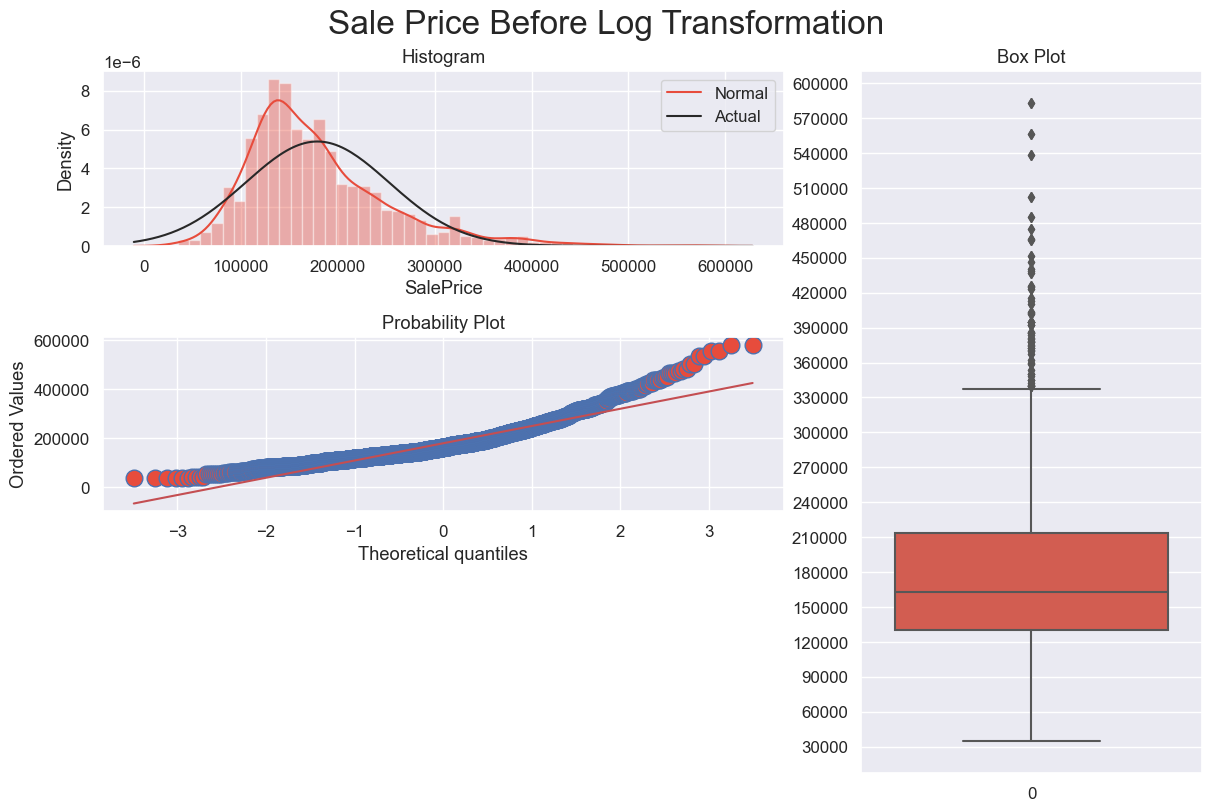

In [44]:
# Checking target variable.
plot_dist3(train.join(y), 'SalePrice', 'Sale Price Before Log Transformation')

# Modelling

In [45]:
# Loading neccesary packages for modelling.

from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, TweedieRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor # This is for stacking part, works well with sklearn and others...

In [136]:
# Setting model data.
X = train
X_test = test
y = np.log1p(y)

In [135]:
np.log1p(y)

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1449, dtype: float64

In [144]:
# Setting kfold for future use.
kf = KFold(10, shuffle=True, random_state=42)

In [145]:
# Some parameters for ridge, lasso and elasticnet.

alphas_alt = [15.5, 15.6, 15.7, 15.8, 15.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [
    5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008
]
e_alphas = [
    0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007
]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

# ridge_cv

ridge = make_pipeline(RobustScaler(), RidgeCV(
    alphas=alphas_alt,
    cv=kf,
))

# lasso_cv:

lasso = make_pipeline(
    RobustScaler(),
    LassoCV(max_iter=10000000, alphas=alphas2, random_state=42, cv=kf))

# elasticnet_cv:

elasticnet = make_pipeline(
    RobustScaler(),
    ElasticNetCV(max_iter=10000000,
                 alphas=e_alphas,
                 cv=kf,
                 random_state=42,
                 l1_ratio=e_l1ratio))

# svr:

svr = make_pipeline(RobustScaler(),
                    SVR(C=21, epsilon=0.0099, gamma=0.00017, tol=0.000121))

# gradientboosting:

gbr = GradientBoostingRegressor(n_estimators=2900,
                                learning_rate=0.0161,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=17,
                                loss='huber',
                                random_state=42)

# lightgbm:

lightgbm = LGBMRegressor(objective='regression',
                         n_estimators=3500,
                         num_leaves=5,
                         learning_rate=0.00721,
                         max_bin=163,
                         bagging_fraction=0.35711,
                         n_jobs=-1,
                         bagging_seed=42,
                         feature_fraction_seed=42,
                         bagging_freq=7,
                         feature_fraction=0.1294,
                         min_data_in_leaf=8)

# xgboost:

xgboost = XGBRegressor(
    learning_rate=0.0139,
    n_estimators=4500,
    max_depth=4,
    min_child_weight=0,
    subsample=0.7968,
    colsample_bytree=0.4064,
    nthread=-1,
    scale_pos_weight=2,
    seed=42,
)


# hist gradient boosting regressor:

hgrd= HistGradientBoostingRegressor(    loss= 'squared_error',
    max_depth= 2,
    min_samples_leaf= 40,
    max_leaf_nodes= 29,
    learning_rate= 0.15,
    max_iter= 225,
                                    random_state=42)

# tweedie regressor:
 
tweed = make_pipeline(RobustScaler(),TweedieRegressor(alpha=0.005))


# stacking regressor:

stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr,
                                            xgboost, lightgbm,hgrd, tweed),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [146]:
def model_check(X, y, estimators, cv):
    
    ''' A function for testing multiple estimators.'''
    
    model_table = pd.DataFrame()

    row_index = 0
    for est, label in zip(estimators, labels):

        MLA_name = label
        model_table.loc[row_index, 'Model Name'] = MLA_name

        cv_results = cross_validate(est,
                                    X,
                                    y,
                                    cv=cv,
                                    scoring='neg_root_mean_squared_error',
                                    return_train_score=True,
                                    n_jobs=-1)

        model_table.loc[row_index, 'Train RMSE'] = -cv_results[
            'train_score'].mean()
        model_table.loc[row_index, 'Test RMSE'] = -cv_results[
            'test_score'].mean()
        model_table.loc[row_index, 'Test Std'] = cv_results['test_score'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1

    model_table.sort_values(by=['Test RMSE'],
                            ascending=True,
                            inplace=True)

    return model_table

In [147]:
# Setting list of estimators and labels for them:
estimators = [ridge, lasso, elasticnet, gbr, xgboost, lightgbm, svr, hgrd, tweed]
labels = [
    'Ridge', 'Lasso', 'Elasticnet', 'GradientBoostingRegressor',
    'XGBRegressor', 'LGBMRegressor', 'SVR', 'HistGradientBoostingRegressor','TweedieRegressor'
]

In [148]:
# Executing cross validation.
raw_models = model_check(X, y, estimators, kf)
display(raw_models.style.background_gradient(cmap='summer_r'))

## XGBoost

In [152]:
# Fit model
xgboost.fit(X,y)
# make predictions for test data
y_pred = np.expm1(xgboost.predict(X_test))


# Infer on submission data
submission = pd.read_csv('data/test.csv')
# Inversing and flooring log scaled sale price predictions
submission['SalePrice'] = y_pred


# Defining outlier quartile ranges
q1 = submission['SalePrice'].quantile(0.0050)
q2 = submission['SalePrice'].quantile(0.99)

# Applying weights to outlier ranges to smooth them
submission['SalePrice'] = submission['SalePrice'].apply(
    lambda x: x if x > q1 else x * 0.77)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x
                                                        if x < q2 else x * 1.1)

                                                    
submission = submission[['Id', 'SalePrice']]
submission.to_csv('xgboost_anomalyfix.csv', index=False)

## Lasso

In [150]:
# Fit model
lasso.fit(X,y)
# make predictions for test data
y_pred = np.expm1(lasso.predict(X_test))

# Infer on submission data
submission = pd.read_csv('data/test.csv')
# Inversing and flooring log scaled sale price predictions
submission['SalePrice'] = y_pred

submission = submission[['Id', 'SalePrice']]
submission.to_csv('lasso.csv', index=False)